The __[MNIST](http://yann.lecun.com/exdb/mnist/)__ database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

In this notebook I will be using Keras to build a Convolutional Neural Network (CNN) for classifying hand written digits. The kNN classifier only got a 94.2% accuracy, and hopefully CNN can do better.

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils.vis_utils import plot_model
import tensorflow as tf


import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, classification_report, roc_curve, roc_auc_score

The Keras library already includes these digits in the keras.datasets module. We will load the digits from this library to save pre-processing time. I am going to use the karas.datasets.mnist.load_data() call. This function conveniently returns two tuples of images & labels - one for the training dataset and the other for test dataset.

In [2]:
(x_train_val, y_train_val), (x_test, y_test) = mnist.load_data()

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify = y_train_val, 
                                                  test_size = 0.2, 
                                                  random_state = 12)

***
**Utility Functions**
***

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [6]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [7]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [8]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth = 2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth = 2, color = colors[6], linestyle = ':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***
**Data Preprocessing**
***

Since the images are not shaped correctly we will need to reshape them into the correct form, convert to float32 and scale as well as one-hot encode the labels.

In [9]:
img_rows, img_cols = 28, 28
num_classes = 10

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_val = x_val.reshape(x_val.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_val /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print('x_val shape:', x_val.shape)
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (48000, 28, 28, 1)
48000 train samples
x_val shape: (12000, 28, 28, 1)
12000 validation samples
10000 test samples


In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

***
**Model Build**
***

Convolutional Neural Networks or ConvNets are popular neural network architectures commonly used in Computer Vision problems like image classification and object detection. 

This course gives an in-depth explanation of how ConvNets work:
__[Convolutional Neural Networks on coursera by Andrew Ng](https://www.coursera.org/learn/convolutional-neural-networks)__

In [11]:
KERAS_METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'), 
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
]

The actual design of neural network is done in this portion of the code. First, we define the model to be a sequential model.

It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. We stack Convolutional Layer and Pooling Layer on top of each other along with Dropout layer. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. Dropout layers provide a simple way to avoid overfitting by randomly dropping components of neural network (outputs) from a layer of neural network. This results in a scenario where at each layer more neurons are forced to learn the multiple characteristics of the neural network. The pooling layer reduces the learned features to 1/2 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction. The last layer of the neural network will have number of node equal to the number of output class i.e. 10 and the activation function we will be using is “softmax”.

The efficient Adam version of stochastic gradient descent will be used to optimize the network, and the categorical cross entropy loss function will be used given that we are learning a multi-class classification problem.

In [12]:
def make_model(metrics = KERAS_METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)       
        
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                         bias_initializer=output_bias))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=KERAS_METRICS)

    return model

***
**Model Architecture**
***

In [13]:
model = make_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

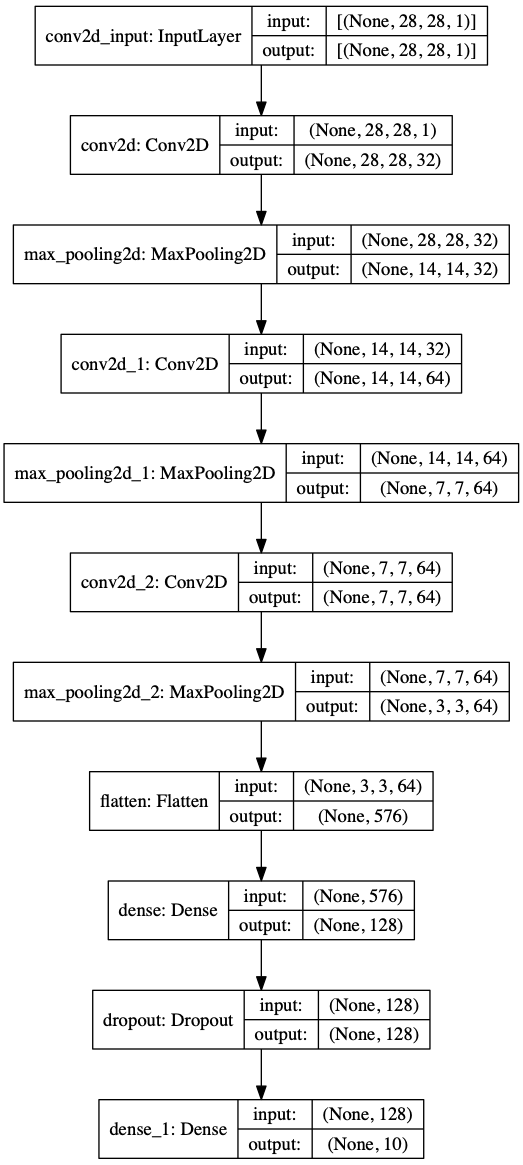

In [14]:
import PIL.Image as Image
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('model_plot.png')
im

**Number of epochs and batch size**

The number of epochs and the batch size are also tunable parameters. We would in general want to use a larger batch size to train the model as it allows computational speed up from the parallelism. However, it is known that too large of a batch size will lead to poor generalization (although currently it’s not known why this is so).  In order to prevent overfitting I will rely on early stopping.

**Early stopping**

When we’re training a learning algorithm iteratively, we can measure how well each iteration of the model performs. Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data. Early stopping refers stopping the training process before the learner passes that point.

In [15]:
# The exact amount of patience will vary between models and problems and is difficult to calculate exactly. 

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy', 
    verbose = 2,
    patience = 10,
    mode = 'max',
    restore_best_weights = True)

In [16]:
callbacks = [early_stopping]

In [17]:
EPOCHS = 100
BATCH_SIZE = 128

In [18]:
history = model.fit(x_train, y_train,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = callbacks,
                    validation_data = (x_val, y_val))

Epoch 1/100
375/375 [==============================] - 56s 146ms/step - loss: 0.7991 - tp: 17926.8378 - fp: 1371.2128 - tn: 215777.7234 - fn: 6200.8218 - accuracy: 0.9571 - precision: 0.8849 - recall: 0.6244 - auc: 0.9441 - val_loss: 0.0805 - val_tp: 11647.0000 - val_fp: 256.0000 - val_tn: 107744.0000 - val_fn: 353.0000 - val_accuracy: 0.9949 - val_precision: 0.9785 - val_recall: 0.9706 - val_auc: 0.9989
Epoch 2/100
375/375 [==============================] - 46s 123ms/step - loss: 0.1301 - tp: 23109.4362 - fp: 688.9654 - tn: 216459.9707 - fn: 1018.2234 - accuracy: 0.9926 - precision: 0.9700 - recall: 0.9556 - auc: 0.9977 - val_loss: 0.0656 - val_tp: 11739.0000 - val_fp: 197.0000 - val_tn: 107803.0000 - val_fn: 261.0000 - val_accuracy: 0.9962 - val_precision: 0.9835 - val_recall: 0.9783 - val_auc: 0.9990
Epoch 3/100
375/375 [==============================] - 53s 140ms/step - loss: 0.0824 - tp: 23471.8697 - fp: 467.1809 - tn: 216681.7553 - fn: 655.7899 - accuracy: 0.9952 - precision: 0.9

The model starts to overfit after about 10 epochs. Without the dropout the model would overfit much faster (after about 5 epochs). As explained before, the dropout layer is intended to provide a simple way to avoid overfitting by randomly dropping components of neural network (outputs) from a layer of neural network.  However, since the results are already pretty good the improvement is minimal.

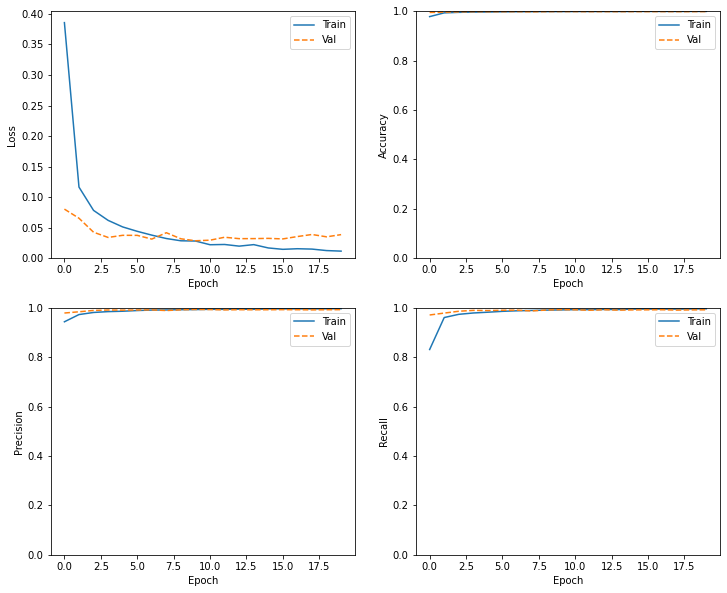

In [19]:
plot_metrics(history)

In [21]:
# Saving the model for later import in Streamlit - Heroku.
model.save("mlmodels/mnist_cnn/")

INFO:tensorflow:Assets written to: mlmodels/mnist_cnn/assets


Let's now see how the model does on the test (unseen) data.

In [20]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Score on test set: ", score[0])
print("Accuracy on test set: ", score[1])

Score on test set:  0.024282287806272507
Accuracy on test set:  9919.0


In [22]:
y_probas_train = model.predict(x_train)
y_probas_test = model.predict(x_test)

In [23]:
# Get most likely class
y_pred_test = np.round(y_probas_test) 

In [24]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

   micro avg       0.99      0.99      0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000
 samples avg       0.99      0.99      0.99     10000



/Users/laura/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
